<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA7_GeneralizedLinearModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLM with `Stan`

In [6]:
!pip list | grep cmdstanpy
!pip list | grep arviz

cmdstanpy                          1.2.5
arviz                              0.20.0


In [7]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp3o40zsva
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [8]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [9]:
# Import modules
import os
import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [10]:
df = pd.read_csv("grouse_data.csv", index_col=0)
df.head()

TICKS  HEIGHT  YEAR  LOCATION
1      0     465    95        32
2      0     465    95        32
3      0     472    95        36
4      0     475    95        37
5      0     475    95        37

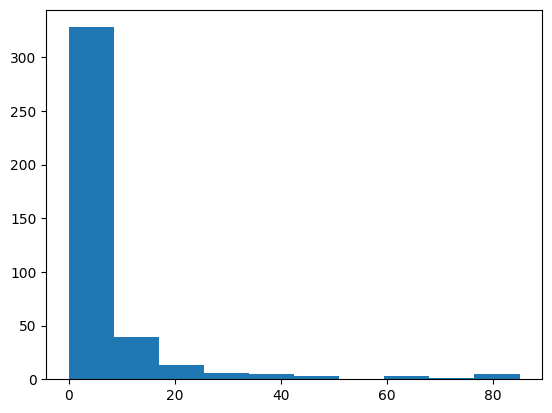

In [11]:
plt.hist(df.TICKS)
plt.show()

Let  $y_i =$ number of ticks on a grouse. As covariates we consider $x_i = [1, h_i]$ where $h_i$ is the height of the place where the grouse lives.

As standard practice we standardize the covariates

The model assumes

\begin{equation*}
    \begin{aligned}
        y_i \mid \beta & \sim \text{Poi}(\exp(x_i^T \, \beta))\\
        \beta_j \mid \sigma_j & \sim \mathcal{N}(0, \sigma_j^2) \\
        \sigma_j &\sim \mathcal{HC}(0, 1)
    \end{aligned}
\end{equation*}

Where $\mathcal{HC}(0, 1)$ is the half-Cauchy distribution (i.e. Cauchy truncated on $[0, +\infty)$ centered in $0$ and with scale $1$

In [12]:
y = df.TICKS.values
h = df.HEIGHT.values
h = (h - np.mean(h)) / np.std(h)

X = np.column_stack([np.ones_like(y), h])
X[:10, :]

array([[1.        , 0.07683549],
       [1.        , 0.07683549],
       [1.        , 0.27175717],
       [1.        , 0.35529503],
       [1.        , 0.35529503],
       [1.        , 0.35529503],
       [1.        , 0.35529503],
       [1.        , 0.71729243],
       [1.        , 0.71729243],
       [1.        , 0.71729243]])

In [13]:
poi_glm = """
data {
    int<lower=0> N;
    int<lower=0> p;
    array[N] int<lower=0> Y;
    matrix[N, p] X;
}

parameters {
    vector[p] beta;
    vector<lower=0>[p] sigma_beta;
}


transformed parameters {
    vector[N] mu;
    for(i in 1:N) {
      mu[i] = exp(row(X, i) * beta);
    }
}

model {
    for (s in 1:N) {
        Y[s] ~ poisson(mu[s]);
    }


    for (j in 1:p) {
        beta[j] ~ normal(0.0, sigma_beta);
        sigma_beta[j] ~ cauchy(0.0, 1.0);
    }
}

generated quantities {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
  }
}
"""

# Write stan model to file
stan_file = "./stan/poisson_glm.stan"
with open(stan_file, "w") as f:
    print(poi_glm, file=f)

# Compile stan model
poi_glm = CmdStanModel(stan_file=stan_file)

21:21:33 - cmdstanpy - INFO - compiling stan file /content/stan/poisson_glm.stan to exe file /content/stan/poisson_glm
INFO:cmdstanpy:compiling stan file /content/stan/poisson_glm.stan to exe file /content/stan/poisson_glm
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poisson_glm.stan /content/stan/poisson_glm
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poisson_glm.stan --o=/content/stan/poisson_glm.hpp /content/stan/poisson_glm.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials  

In [14]:
# Input data
glm_data = {
    "N": len(y),
    "p": X.shape[1],
    "Y": y,
    "X": X
}

# Sample
poi_glm_fit = poi_glm.sample(data=glm_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert to arviz data type
poi_glm_data = az.from_cmdstanpy(poi_glm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poisson_glm info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/98wexo7x.json
21:23:45 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poisson_glm', 'id=1', 'random', 'seed=9410', 'data', 'file=/tmp/tmpzu0qy9kr/98wexo7x.json', 'output', 'file=/tmp/tmpzu0qy9kr/poisson_glmkb35x6u9/poisson_glm-20250208212346_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poisson_glm', 'id=2', 'random', 'seed=9410', 'data', 'file=/tmp/tmpzu0qy9kr/98wexo7x.json', 'output', 'file=/tmp/tmpzu0qy9kr/poisson_glmkb35x6u9/poisson_glm-20250208212346_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poisson_glm', 'id=3', 'random', 'seed=9410', 'data', 'file=/tmp/tmpzu0qy9kr/98wexo7x.json', 'output', 

21:24:07 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poisson_glm', 'id=1', 'random', 'seed=9410', 'data', 'file=/tmp/tmpzu0qy9kr/98wexo7x.json', 'output', 'file=/tmp/tmpzu0qy9kr/poisson_glmkb35x6u9/poisson_glm-20250208212346_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poisson_glmkb35x6u9/poisson_glm-20250208212346_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poisson_glmkb35x6u9/poisson_glm-20250208212346_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta

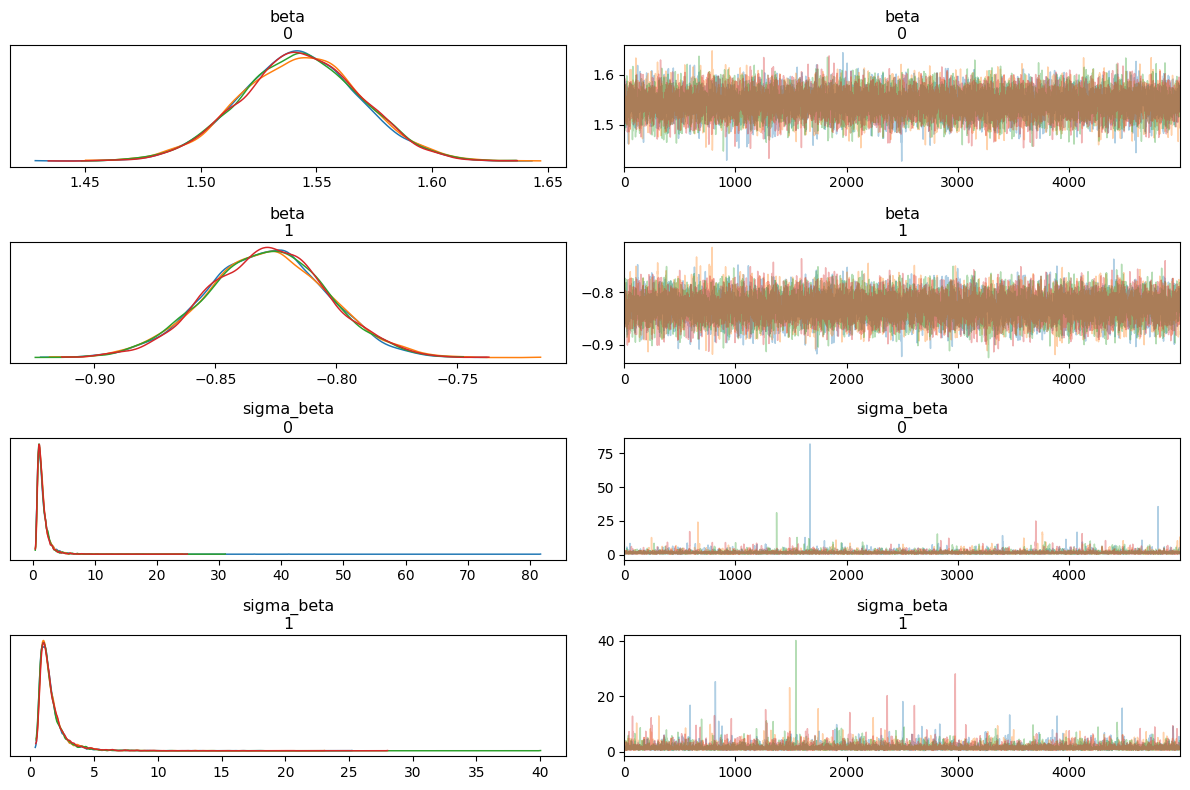

In [15]:
az.plot_trace(poi_glm_data, var_names=["beta", "sigma_beta"], compact=False)
plt.tight_layout()
plt.show()

In [16]:
np.sum(poi_glm_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

# Incorporating additional information in the model

We have that data are divided by years (95, 96, 97).

How can we take this into account?

Of course adding the year as a linear predictor makes very litte sense


## Mixed models

We consider that there is a "random effect" specific for each year:

\begin{equation*}
    \begin{aligned}
        y_{i,t} \mid  \mu_{i, t} & \sim \text{Poi}(\mu_{i, t})\\
        \mu_{i, t} & = \exp \left(x_i^T \beta + \lambda_t \right) \\
        \beta_j \mid \sigma_j & \sim \mathcal{N}(0, \sigma_j^2) \\
        \sigma_j &\sim \mathcal{HC}(0, 1) \\
        \lambda_1, \ldots, \lambda_T \mid \lambda_0, s_0 & \sim \mathcal{N}(\lambda_0, s_0)\\
        \lambda_0, s_0 & \sim \mathcal{N}(\lambda_{00}, \tau_0) \times \mathcal{HC}(0, 1)
    \end{aligned}
\end{equation*}

Where $y_{i, t}$ makes the dependence on the year explicit ($t$).

Here $\lambda_t$ is a random intercept specific of the year

A more convenient formulation is

\begin{equation*}
    \begin{aligned}
        y_{i} \mid  & \sim \text{Poi}(\mu_{i})\\
        \mu_{i} & = \exp \left(x_i^T \beta + g_i^T \lambda \right) \\
        \beta_j \mid \sigma_j & \sim \mathcal{N}(0, \sigma_j^2) \\
        \sigma_j &\sim \mathcal{HC}(0, 1) \\
        \lambda_1, \ldots, \lambda_T \mid \lambda_0, s_0 & \sim \mathcal{N}(\lambda_0, s_0)\\
        \lambda_0, s_0 & \sim \mathcal{N}(\lambda_{00}, \tau_0) \times \mathcal{HN}(0, 3)
    \end{aligned}
\end{equation*}

where $\lambda = (\lambda_1, \lambda_2, \lambda_3)^T$ and $g_i$ is an indicator vector (i.e. $g_i[h] = 1$ iff observation $i$ belongs to group $h$)

We fix $\lambda_{00} = 0$, $\tau_{0} = 3$.

In [17]:
poi_glmm_grouse = """
data {
    int<lower = 0> N;
    int<lower = 0> p_fix;
    int<lower = 0> n_groups;

    array[N] int<lower=0> Y;
    matrix[N, p_fix] X;
    matrix[N, n_groups] G;
}

parameters {
    vector[p_fix] beta;
    vector<lower=0>[p_fix] sigma_beta;

    vector[n_groups] lambda_raw;
    real lambda0;
    real<lower=0> s0;
}

transformed parameters  {
    vector[n_groups] lambda;
    vector[N] mu;

    lambda = lambda0 + lambda_raw * s0;

    mu = exp(X * beta + G * lambda);
}

model {
    for (s in 1:N) {
        Y[s] ~ poisson(mu[s]);
    }

    for (j in 1:p_fix) {
        beta[j] ~ normal(0.0, sigma_beta[j]);
        sigma_beta[j] ~ cauchy(0.0, 1.0);
    }

    lambda_raw ~ normal(0.0, 1.0);
    lambda0 ~ normal(0.0, 3.0);
    s0 ~ normal(0.0, 3.0);
}

generated quantities  {
      vector[N] log_lik;
      for (j in 1:N) {
            log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
      }
}
"""

# Write stan model to file
stan_file = "./stan/poi_glmm_grouse.stan"
with open(stan_file, "w") as f:
    print(poi_glmm_grouse, file=f)

# Compile model
poi_glmm = CmdStanModel(stan_file=stan_file)

21:24:37 - cmdstanpy - INFO - compiling stan file /content/stan/poi_glmm_grouse.stan to exe file /content/stan/poi_glmm_grouse
INFO:cmdstanpy:compiling stan file /content/stan/poi_glmm_grouse.stan to exe file /content/stan/poi_glmm_grouse
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poi_glmm_grouse.stan /content/stan/poi_glmm_grouse
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poi_glmm_grouse.stan --o=/content/stan/poi_glmm_grouse.hpp /content/stan/poi_glmm_grouse.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_ma

In [18]:
years = df.YEAR.values
G = (years[:, np.newaxis] == np.unique(years)).astype(int)

In [19]:
glmm_data = {
    "N": len(y),
    "p_fix": X.shape[1],
    "n_groups": G.shape[1],
    "Y": y,
    "X": X,
    "G": G
}

poi_glmm_fit = poi_glmm.sample(data=glmm_data, chains=4, parallel_chains=4,
                               iter_warmup=1000, iter_sampling=1000)

poi_glmm_data = az.from_cmdstanpy(poi_glmm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glmm_grouse info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/h70xlcm8.json
21:25:25 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=1', 'random', 'seed=16802', 'data', 'file=/tmp/tmpzu0qy9kr/h70xlcm8.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse39kpbuce/poi_glmm_grouse-20250208212525_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=2', 'random', 'seed=16802', 'data', 'file=/tmp/tmpzu0qy9kr/h70xlcm8.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse39kpbuce/poi_glmm_grouse-20250208212525_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=3', 'random', 'seed=16802', 'data', 'file=/tmp/tmpzu0q

21:27:37 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glmm_grouse', 'id=1', 'random', 'seed=16802', 'data', 'file=/tmp/tmpzu0qy9kr/h70xlcm8.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse39kpbuce/poi_glmm_grouse-20250208212525_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glmm_grouse39kpbuce/poi_glmm_grouse-20250208212525_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glmm_grouse39kpbuce/poi_glmm_grouse-20250208212525_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
 

21:27:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Chain 2 had 15 divergent transitions (1.5%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 3 had 1 iterations at max treedepth (0.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Chain 4 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Chain 2 had 15 divergent transitions (1.5%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 3 had 1 iterations at max treedepth (0.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Chain 4 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


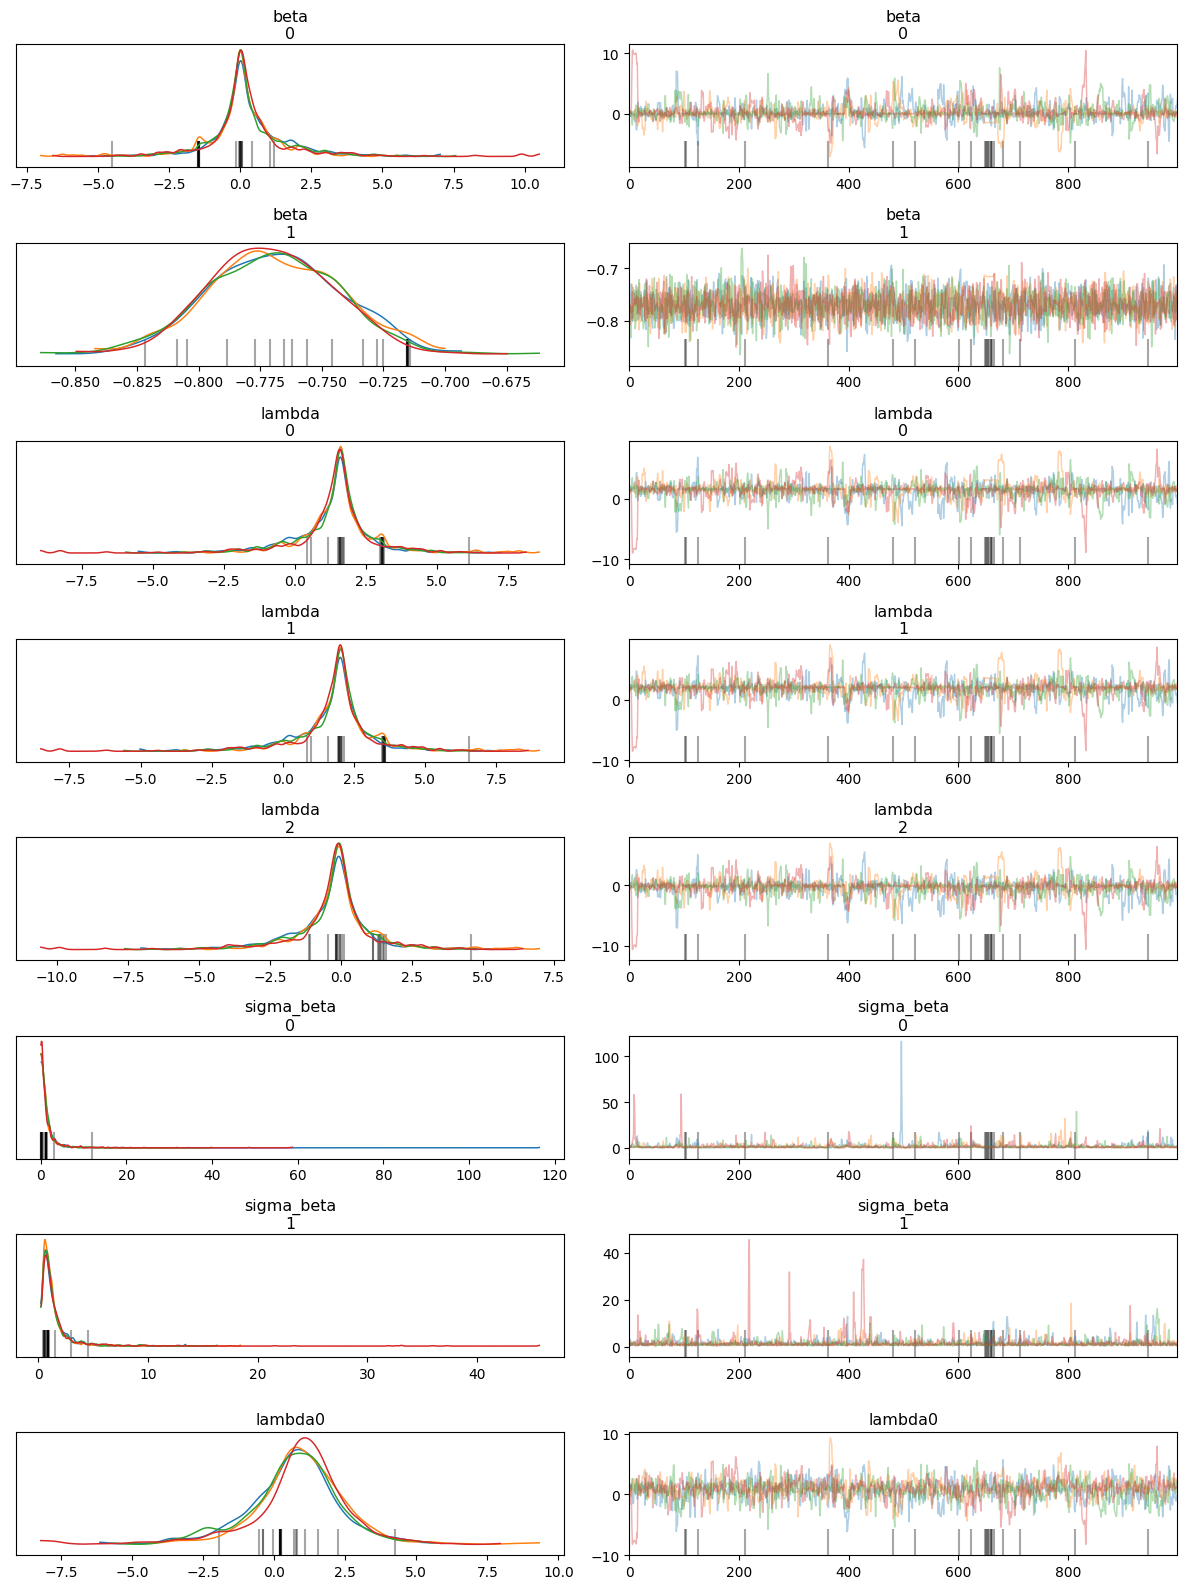

In [20]:
az.plot_trace(poi_glmm_data, var_names=[
    "beta", "lambda", "sigma_beta", "lambda0"], compact=False)
plt.tight_layout()
plt.show()

### Oh no, some divergent iterations! Let's try and increase `adapt_delta` and/or the `max_treedepth`

In [21]:
poi_glmm_fit = poi_glmm.sample(
    data=glmm_data, chains=4, parallel_chains=4, adapt_delta=0.999, max_treedepth=15)
poi_glmm_data = az.from_cmdstanpy(poi_glmm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glmm_grouse info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/_6hkjdqk.json
21:27:52 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=1', 'random', 'seed=57916', 'data', 'file=/tmp/tmpzu0qy9kr/_6hkjdqk.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_1.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.999']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=2', 'random', 'seed=57916', 'data', 'file=/tmp/tmpzu0qy9kr/_6hkjdqk.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_2.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.999']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_grouse', 'id=3', 'random', 'seed=57916', 'data', 'fil

21:35:48 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glmm_grouse', 'id=1', 'random', 'seed=57916', 'data', 'file=/tmp/tmpzu0qy9kr/_6hkjdqk.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_1.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.999']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Def

21:35:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [22]:
poi_glmm_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpzu0qy9kr/stansummary-poi_glmm_grouse-jpygo99w.csv /tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_1.csv /tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_2.csv /tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_3.csv /tmp/tmpzu0qy9kr/poi_glmm_grouse8pvc4i9p/poi_glmm_grouse-20250208212752_4.csv
cwd: None


Mean      MCSE    StdDev       MAD           5%  \
lp__           3381.880000  0.080371  2.401300  2.298030  3377.570000   
beta[1]           0.232564  0.045400  1.321390  0.668327    -1.731610   
beta[2]          -0.770359  0.000446  0.025020  0.025796    -0.811318   
sigma_beta[1]     1.461760  0.055786  2.079530  0.858362     0.071353   
sigma_beta[2]     1.463680  0.050431  1.755420  0.591165     0.414675   
...                    ...       ...       ...       ...          ...   
log_lik[399]     -1.755730  0.002289  0.141492  0.141210    -1.992470   
log_lik[400]     -1.872460  0.002446  0.151207  0.150662    -2.123780   
log_lik[401]     -1.872460  0.002446  0.151207  0.150662    -2.123780   
log_lik[402]     -1.522450  0.001041  0.063724  0.062388    -1.633220   
log_lik[403]     -1.219230  0.001595  0.098364  0.098074    -1.382860   

                       50%          95%  ESS_bulk  ESS_tail    R_hat  
lp__           3382.190000  3385.160000   887.737  1861.140  1.00117  
beta[1]           0.064384     2.588100   980.439   978.532  1.00633  
beta[2]          -0.770052    -0.730223  3159.740  2750.500  1.00012  
sigma_beta[1]     0.842626     4.988990   971.917  1602.860  1.00474  
sigma_beta[2]     0.985667     4.045740  2171.930  1441.850  1.00171  
...                    ...          ...       ...       ...      ...  
log_lik[399]     -1.753550    -1.530280  3835.140  2519.040  1.00159  
log_lik[400]     -1.869430    -1.632030  3835.370  2493.220  1.00150  
log_lik[401]     -1.869430    -1.632030  3835.370  2493.220  1.00150  
log_lik[402]     -1.516410    -1.427690  3812.800  2457.780  1.00157  
log_lik[403]     -1.218500    -1.063840  3812.760  2457.780  1.00173  

[819 rows x 10 columns]

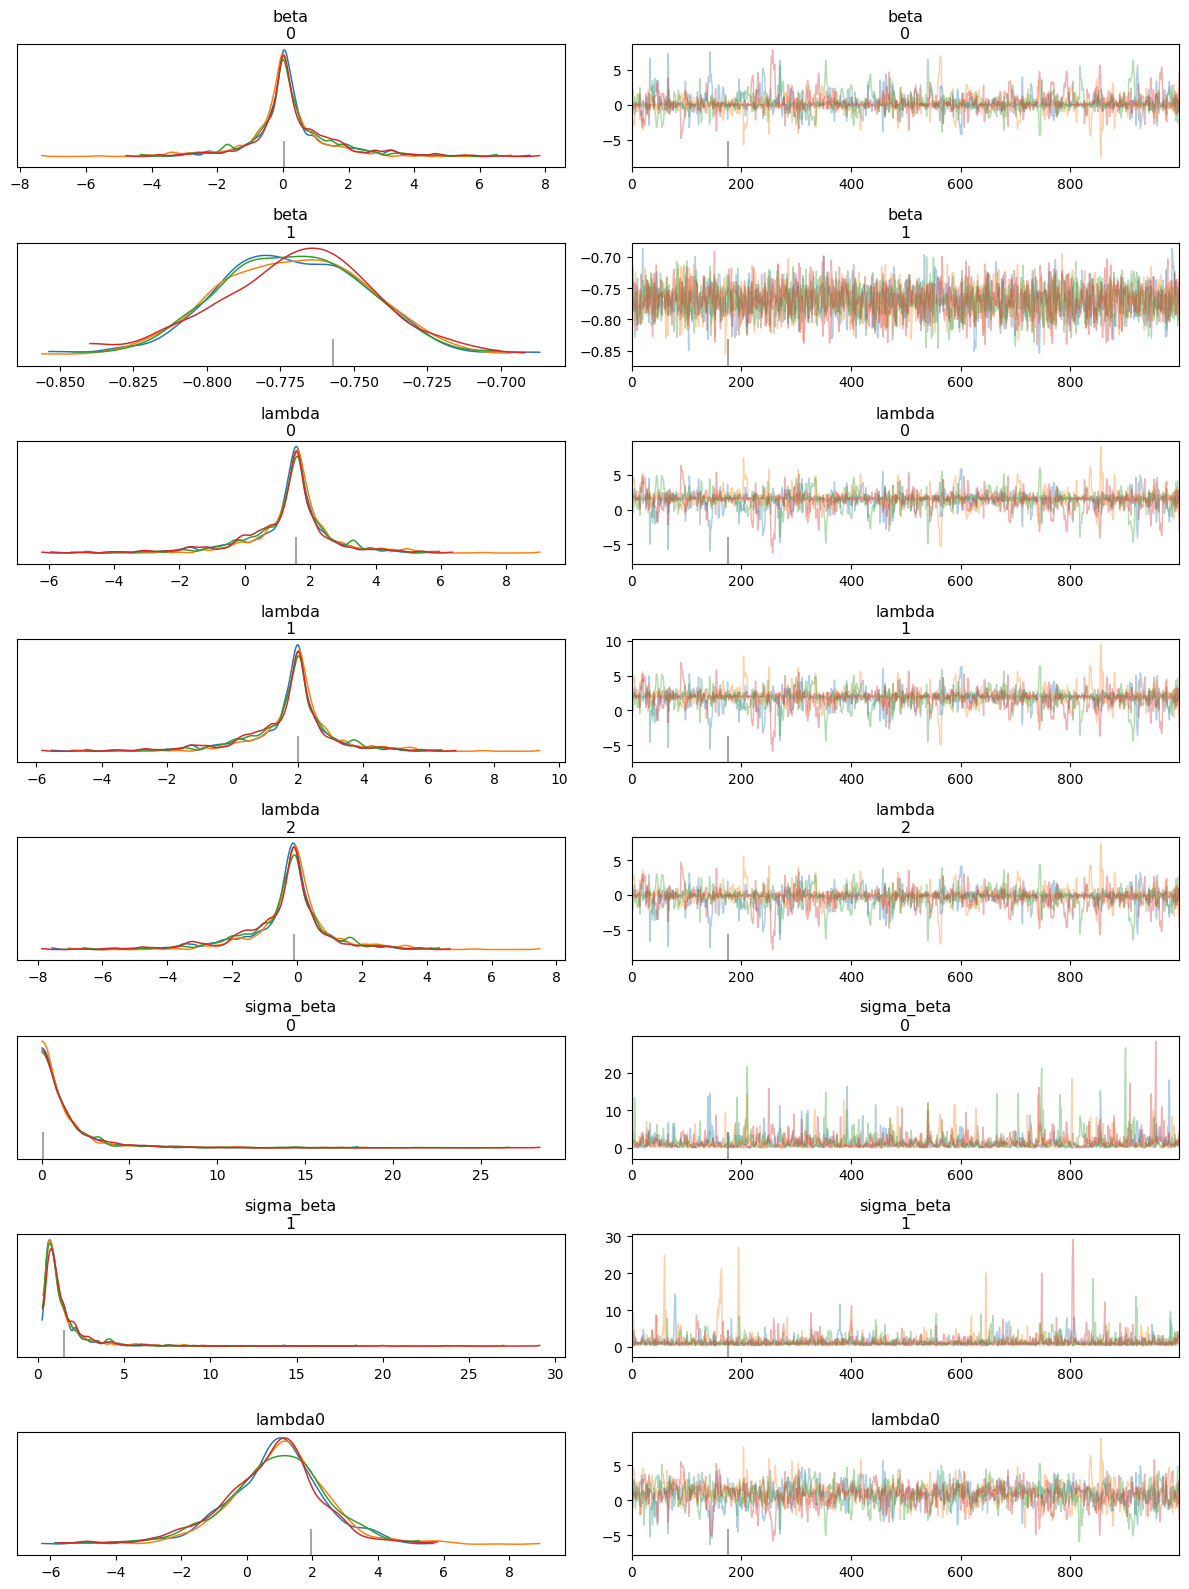

In [23]:
az.plot_trace(poi_glmm_data, var_names=[
    "beta", "lambda", "sigma_beta", "lambda0"], compact=False)
plt.tight_layout()
plt.show()

In [24]:
np.sum(poi_glmm_data.sample_stats.diverging)
# we can live with that, but we should remove the divergent iteration

<xarray.DataArray 'diverging' ()> Size: 8B
array(1)

## Which model achieves the best fit? - WAIC and PSIS-LOO-CV
Both definitions of *WAIC* and *PSIS-LOO-CV* comes from [Vehtari et al. (2016)][1].

<!-- References -->
[1]: https://link.springer.com/article/10.1007/s11222-016-9696-4

In [25]:
print("GLM-WAIC: ", az.waic(poi_glm_data, var_name="log_lik"))
print("GLMM-WAIC: ", az.waic(poi_glmm_data, var_name="log_lik"))

GLM-WAIC:  Computed from 20000 posterior samples and 403 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2738.76   298.19
p_waic       37.46        -

There has been a warning during the calculation. Please check the results.
GLMM-WAIC:  Computed from 4000 posterior samples and 403 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2222.55   247.10
p_waic       62.23        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [26]:
print("GLM-LOO: ", az.loo(poi_glm_data, var_name="log_lik"))
print("GLMM-LOO: ", az.loo(poi_glmm_data, var_name="log_lik"))

GLM-LOO:  Computed from 20000 posterior samples and 403 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2738.81   298.22
p_loo       37.51        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      403  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

GLMM-LOO:  Computed from 4000 posterior samples and 403 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2221.18   246.65
p_loo       60.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      398   98.8%
   (0.70, 1]   (bad)         3    0.7%
   (1, Inf)   (very bad)    2    0.5%



/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [27]:
az.compare({"GLM": poi_glm_data, "GLMM": poi_glmm_data})

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo   elpd_diff    weight          se  \
GLMM     0 -2221.175227  60.851181    0.000000  0.641283  246.651809   
GLM      1 -2738.807122  37.513268  517.631896  0.358717  298.219193   

            dse  warning scale  
GLMM   0.000000     True   log  
GLM   96.138514    False   log

# What is the predictive distribution?

Suppose we have a new covariate $x^*$, what is the distribution of the associated $y^*$?

1. For the GLM:

\begin{equation*}
    \begin{aligned}
        y_i \mid \beta & \sim \text{Poi}(\exp(x_i^T \, \beta))\\
        \beta_j \mid \sigma_j & \sim \mathcal{N}(0, \sigma_j^2) \\
        \sigma_j &\sim \mathcal{HC}(0, 1)
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        \mathcal{L}(y^* \mid \mathbf{y}) &= \int \mathcal{L}(y^* \mid \beta, \mathbf{y}) \mathcal{L}(\beta \mid \mathbf{y}) \mathrm d \beta \\
        & \approx \frac{1}{M} \sum_{j=1}^M \text{Poi}(\exp(x^* \, \beta^{(j)})
    \end{aligned}
\end{equation*}


2. For the GLMM, when the observation belongs to one of the observed groups

\begin{equation*}
    \begin{aligned}
        y_{i,t} \mid  \lambda_t, \beta & \sim \text{Poi}(\exp \left(x_i^T \beta + \lambda_t \right))\\
        \beta_j \mid \sigma_j & \sim \mathcal{N}(0, \sigma_j^2) \\
        \sigma_j &\sim \mathcal{HC}(0, 1) \\
        \lambda_1, \ldots, \lambda_T \mid \lambda_0, s_0 & \sim \mathcal{N}(\lambda_0, s_0)\\
        \lambda_0, s_0 & \sim \mathcal{N}(\lambda_{00}, \tau_0) \times \mathcal{HN}(0, 3)
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        \mathcal{L}(y^* \mid \mathbf{y}) &= \int \mathcal{L}(y^* \mid \lambda_t, \beta, \mathbf{y}) \mathcal{L}(\lambda_t, \beta \mid \mathbf{y}) \mathrm d \beta \\
        & \approx \frac{1}{M} \sum_{j=1}^M \text{Poi}(\exp \left(x^* \beta^{(j)} + \lambda_t^{(j)} \right))
    \end{aligned}
\end{equation*}

3. For the GLMM, when the observation belongs to a new group! We need to consider also the law of $\lambda^*$

\begin{equation*}
    \begin{aligned}
        \mathcal{L}(y^* , \lambda^* \mid \mathbf{y}) &= \int \mathcal{L}(y^*, \lambda^* \mid \beta, \{\lambda_j\}, \lambda_0, s_0, \mathbf{y}) \mathcal{L}(d \beta, \{d \lambda_j\}, d \lambda_0, d s_0 \mid \mathbf y) \\
        &= \int \mathcal{L}(y^* \mid \lambda^*, \beta) \mathcal{L}(\lambda^* \mid \beta, \{\lambda_j\}, \lambda_{0}, s_0, \mathbf{y}) \mathcal{L}(d \beta, \{d \lambda_j\}, d \lambda_0, d s_0 \mid \mathbf y) \\
        &= \int \mathcal{L}(y^* \mid \lambda_t, \beta) \mathcal{L}(\lambda_t \mid \lambda_{0}, s_0) \mathcal{L}(d \beta, \{d \lambda_j\}, d \lambda_0, d s_0 \mid \mathbf y) \\
    \end{aligned}
\end{equation*}

So that
$$
     \mathcal{L}(y^* , \lambda^* \mid \mathbf{y}) = \int \mathcal{L}(y^*, \lambda^* \mid \mathbf{y}) d \lambda^*
$$

We can approximate this integral with

$$
\frac{1}{M} \sum_{j=1}^M \text{Poi}(\exp \left(x^* \beta^{(j)} + \lambda^{*(j)} \right))
$$
where $\beta^{(j)}$ is the draw from the MCMC chain and $\lambda^{*(j)} \sim \mathcal{N}(\lambda_0^{(j)}, s_0^{(j)} )$

In [28]:
# All of these quantities can be computed either in stan
# (generated quantities block)
# or directly in Python

In [29]:
def predictive_poi_glm(x_star, chains, ygrid):
    """Evaluates P(y=k | x^*, chains) for k in ygrid"""
    betas = np.vstack(chains.posterior.beta)
    means = np.exp(betas @ x_star)
    out = np.mean(tfd.Poisson(means).prob(ygrid[:, np.newaxis]),
                  axis=1)
    return out

In [30]:
def predictive_poi_glmm(x_star, group, chains, ygrid):
    betas = np.vstack(chains.posterior.beta)
    lambdas = np.vstack(chains.posterior["lambda"])
    means = np.exp(betas @ x_star + lambdas[:, group])
    out = np.mean(tfd.Poisson(means).prob(ygrid[:, np.newaxis]), axis=1)
    return out

In [31]:
def predictive_poi_glmm_newgroup(x_star, chains, ygrid):
    """Evaluates P(y=k | x^*, chains) for k in ygrid"""
    betas = np.vstack(chains.posterior.beta)
    lambda0 = np.ravel(chains.posterior["lambda0"])
    s0 = np.ravel(chains.posterior["s0"])
    lambdas = tfd.Normal(lambda0, s0).sample()
    means = np.exp(betas @ x_star + lambdas)
    out = np.mean(tfd.Poisson(means).prob(ygrid[:, np.newaxis]), axis=1)
    return out

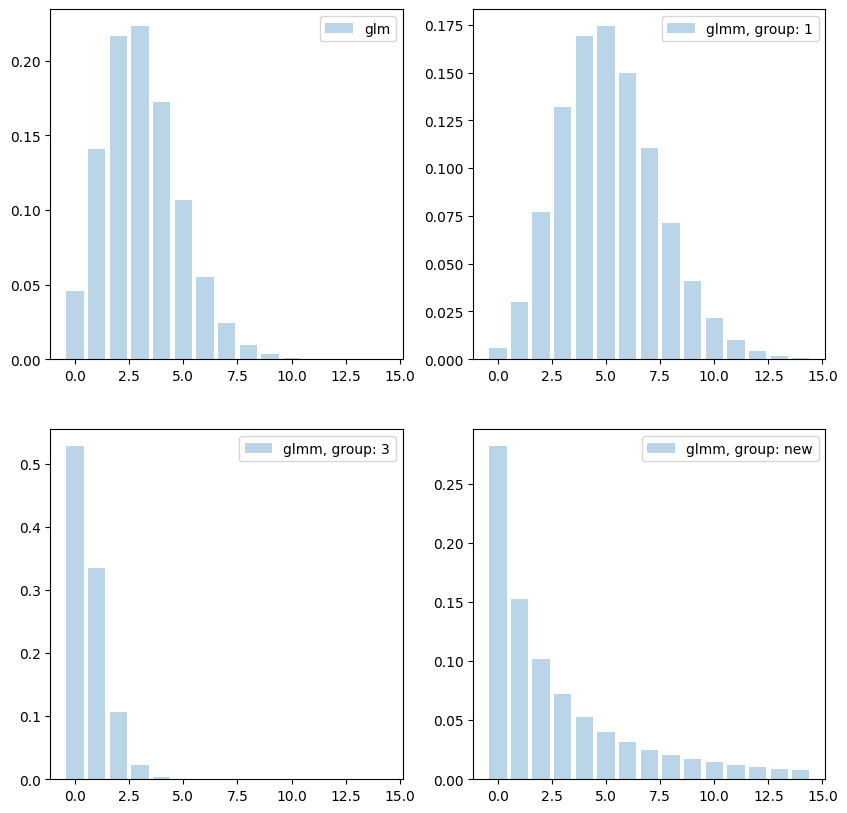

In [32]:
x_star = np.array([1.0, 0.5])
ygrid = np.arange(0, 15)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

pred = predictive_poi_glm(x_star, poi_glm_data, ygrid)
axes[0][0].bar(ygrid, pred, label="glm", alpha=0.3)

pred = predictive_poi_glmm(x_star, 1, poi_glmm_data, ygrid)
axes[0][1].bar(ygrid, pred, label="glmm, group: {0}".format(1), alpha=0.3)

pred = predictive_poi_glmm(x_star, 2, poi_glmm_data, ygrid)
axes[1][0].bar(ygrid, pred, label="glmm, group: {0}".format(3), alpha=0.3)

pred = predictive_poi_glmm_newgroup(x_star, poi_glmm_data, ygrid)
axes[1][1].bar(ygrid, pred, label="glmm, group: {0}".format("new"), alpha=0.3)

for ax in axes.flatten():
    ax.legend()
plt.show()

# A more challenging example: the Ant abundance dataset

The dataset contains 60 observations: each observation measures the number of ants found on a tree.  
For each tree we observe/know:

1. Trap days: how many days the tree was surveyed
2. Elevation: High (1) or Low (2)
3. Valley: three different valleys for each elevation --> nested within the elevation!
4. Number of ants

Moreover we know:

- the summer precipitation (avg)
- the summer temperature (avg)

Let $y_{i, j, r}$ the number of ants observed on tree $i$, at elevation $j$ and valley $r$.  
We assume:

\begin{align*}
    y_{i, j, r} & \sim \text{Poi}(\mu_{i, j, r}) \\
    \mu_{i, j, r} &= \exp(\theta_j + \alpha_{j, r} + \beta^T x_i + \gamma_j^T z_{i, j} )
\end{align*}

Some terminology:

- $\theta_j$ is a random intercept $\to$ group (elevation) specific;
- $\alpha_{j, r}$ is another random intercept $\to$ group (elevation) AND subgroup (valley) specific;
- $x_i$ form the fixed effect design matrix, $\beta$ are the fixed regression coefficients;
- $z_{ij}$ form the RANDOM effect design matrix, $\gamma_j$ are the random effect regression coefficients.

In our case $x_i =$ "trap days", $z_{ij} = (z_{ij1}, z_{ij2})$ = (average precipitation, average temperature).

<!---
We complete the model with priors as before
\begin{align*}
   \beta_j \mid \sigma^\beta_j & \sim \mathcal{N}(0, \sigma^{\beta_j 2})\\
   \sigma^{\beta_j} &\sim \mathcal{HC}(0, 1)\\
   \gamma_j \mid \sigma^\gamma_j & \sim \mathcal{N}(0, \sigma^{\gamma 2}_j) \\
   \sigma^{\gamma_j} &\sim \mathcal{HC}(0, 1) \\
   \alpha_{rj} \mid \sigma^\alpha_{rj} & \sim \mathcal{N}(0, \sigma^{\alpha 2}_{rj}) \\
   \sigma^{\alpha_{rj}} &\sim \mathcal{HC}(0, 1)
\end{align*}
--->

In [33]:
poi_glm_rand_eff = """
data{
    int<lower = 0> N;
    int<lower = 0> ngr;
    int<lower = 0> nsubgr;

    int<lower = 0> p_fix;
    int<lower = 0> p_ran;

    array[N] int<lower = 0> Y;
    matrix[N, p_fix] X;
    matrix[N, p_ran] Z;

    array[N] int<lower=1, upper=ngr> group;
    array[N] int<lower=1, upper=nsubgr> subgroup;
}

parameters{
    vector[p_fix] beta;            // regression coefficients (fixed)
    vector[ngr] theta;             // (group specific) random intercept
    matrix[ngr, p_ran] gamma;      // regression coefficients (random)
    vector[nsubgr] alpha;          // (group specific) random effects

    vector<lower=0>[p_fix] sigma_beta;        // variances for the prior on beta
    vector<lower=0>[ngr] sigma_theta;         // variances for the prior on theta
    matrix<lower=0>[ngr, p_ran] sigma_gamma;  // (group specific) random effects
    vector<lower=0>[nsubgr] sigma_alpha;      // (group specific) random effects
}

transformed parameters{
    vector[N] mu;
    vector[N] intercept;
    vector[N] fix_eff;
    vector[N] rand_eff;

    intercept = theta[group] + alpha[subgroup];
    fix_eff = X * beta;
    for (i in 1:N) {
        rand_eff[i] = dot_product(Z[i], gamma[group[i]]);
    }

    mu = exp(intercept + fix_eff + rand_eff);
}

model{
    for (s in 1:N) {
        Y[s] ~ poisson(mu[s]);
    }

    for (j in 1:p_fix) {
        beta[j] ~ normal(0.0, sigma_beta[j]);
        sigma_beta[j] ~ cauchy(0, 1);
    }

    for (j in 1:ngr) {
        theta[j] ~ normal(0.0, sigma_theta[j]);
        sigma_theta[j] ~ cauchy(0, 1);
    }

    for (j in 1:nsubgr){
        alpha[j] ~ normal(0.0, sigma_alpha);
        sigma_alpha[j] ~ cauchy(0, 1);
    }

    for (j in 1:p_ran) {
      for(i in 1:ngr){
        gamma[j,i] ~ normal(0.0, sigma_gamma[j,i]);
        sigma_gamma[j,i] ~ cauchy(0, 1);
      }
    }

}

generated quantities {
      vector[N] log_lik;
      for (j in 1:N){
        log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
      }
}
"""

# Write stan model to file
stan_file = "./stan/poi_glmm_rand_eff.stan"
with open(stan_file, "w") as f:
    print(poi_glm_rand_eff, file=f)

# Compile stan model
poi_glmm_rand_eff = CmdStanModel(stan_file=stan_file)

21:37:56 - cmdstanpy - INFO - compiling stan file /content/stan/poi_glmm_rand_eff.stan to exe file /content/stan/poi_glmm_rand_eff
INFO:cmdstanpy:compiling stan file /content/stan/poi_glmm_rand_eff.stan to exe file /content/stan/poi_glmm_rand_eff
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poi_glmm_rand_eff.stan /content/stan/poi_glmm_rand_eff
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poi_glmm_rand_eff.stan --o=/content/stan/poi_glmm_rand_eff.hpp /content/stan/poi_glmm_rand_eff.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -

In [34]:
ant_data = pd.read_csv("ant_abundance.csv")
ant_data.head()

year elevation      valley  site  trap.days  num.fpodz  annual.precip  \
0  2015      High  East River   ER1         10          1        1150.45   
1  2015      High  East River  ER10         10          0         684.24   
2  2015      High  East River   ER2         10          2        1150.45   
3  2015      High  East River   ER3         10          0        1150.45   
4  2015      High  East River   ER4         10          3        1354.83   

   summer.precip  annual.temp  summer.temp  snowmelt.doy  mound.area  
0          67.46         2.28        10.21       141.778    0.215875  
1          45.52         2.63        11.26       141.696    0.467075  
2          67.46         2.28        10.21       141.655    1.895775  
3          67.46         2.28        10.21       141.819    0.357175  
4          67.76         1.98         9.68       142.393    0.306150

In [35]:
np.unique(ant_data["valley"].values)

array(['Cement Creek', 'East River', 'Slate River', 'Spring Creek',
       'Taylor River', 'Washington Gulch'], dtype=object)

In [36]:
y = ant_data["num.fpodz"].values
X = ant_data["trap.days"].values.reshape(-1, 1)
Z = ant_data[["summer.precip", "summer.temp"]].values
group = (ant_data["elevation"].values == "High").astype(int) + 1
subgroup = np.where(
    ant_data["valley"].values[:, np.newaxis] ==
        np.unique(ant_data["valley"].values))[1] + 1

In [37]:
glmm_randeff_data = {
    "N": len(y),
    "ngr": len(np.unique(group)),
    "nsubgr": len(np.unique(subgroup)),
    "p_fix": X.shape[1],
    "p_ran": Z.shape[1],
    "Y": y,
    "X": X,
    "Z": Z,
    "group": group,
    "subgroup": subgroup
}

poi_glmm_rand_eff_fit = poi_glmm_rand_eff.sample(
    data=glmm_randeff_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

poi_glmm_rand_eff_data = az.from_cmdstanpy(poi_glmm_rand_eff_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glmm_rand_eff info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/8b4lq3ri.json
21:38:58 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_eff', 'id=2', 'random', 'seed=17559', 'data', 'file=/tmp/tmpzu0qy9kr/8b4lq3ri.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjv09njsw/poi_glmm_rand_eff-20250208213858_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_eff', 'id=1', 'random', 'seed=17559', 'data', 'file=/tmp/tmpzu0qy9kr/8b4lq3ri.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjv09njsw/poi_glmm_rand_eff-20250208213858_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_eff', 'id=3', 'random', 'seed=17559', 'data', 'fil

21:41:25 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glmm_rand_eff', 'id=1', 'random', 'seed=17559', 'data', 'file=/tmp/tmpzu0qy9kr/8b4lq3ri.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjv09njsw/poi_glmm_rand_eff-20250208213858_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glmm_rand_effjv09njsw/poi_glmm_rand_eff-20250208213858_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glmm_rand_effjv09njsw/poi_glmm_rand_eff-20250208213858_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = tr

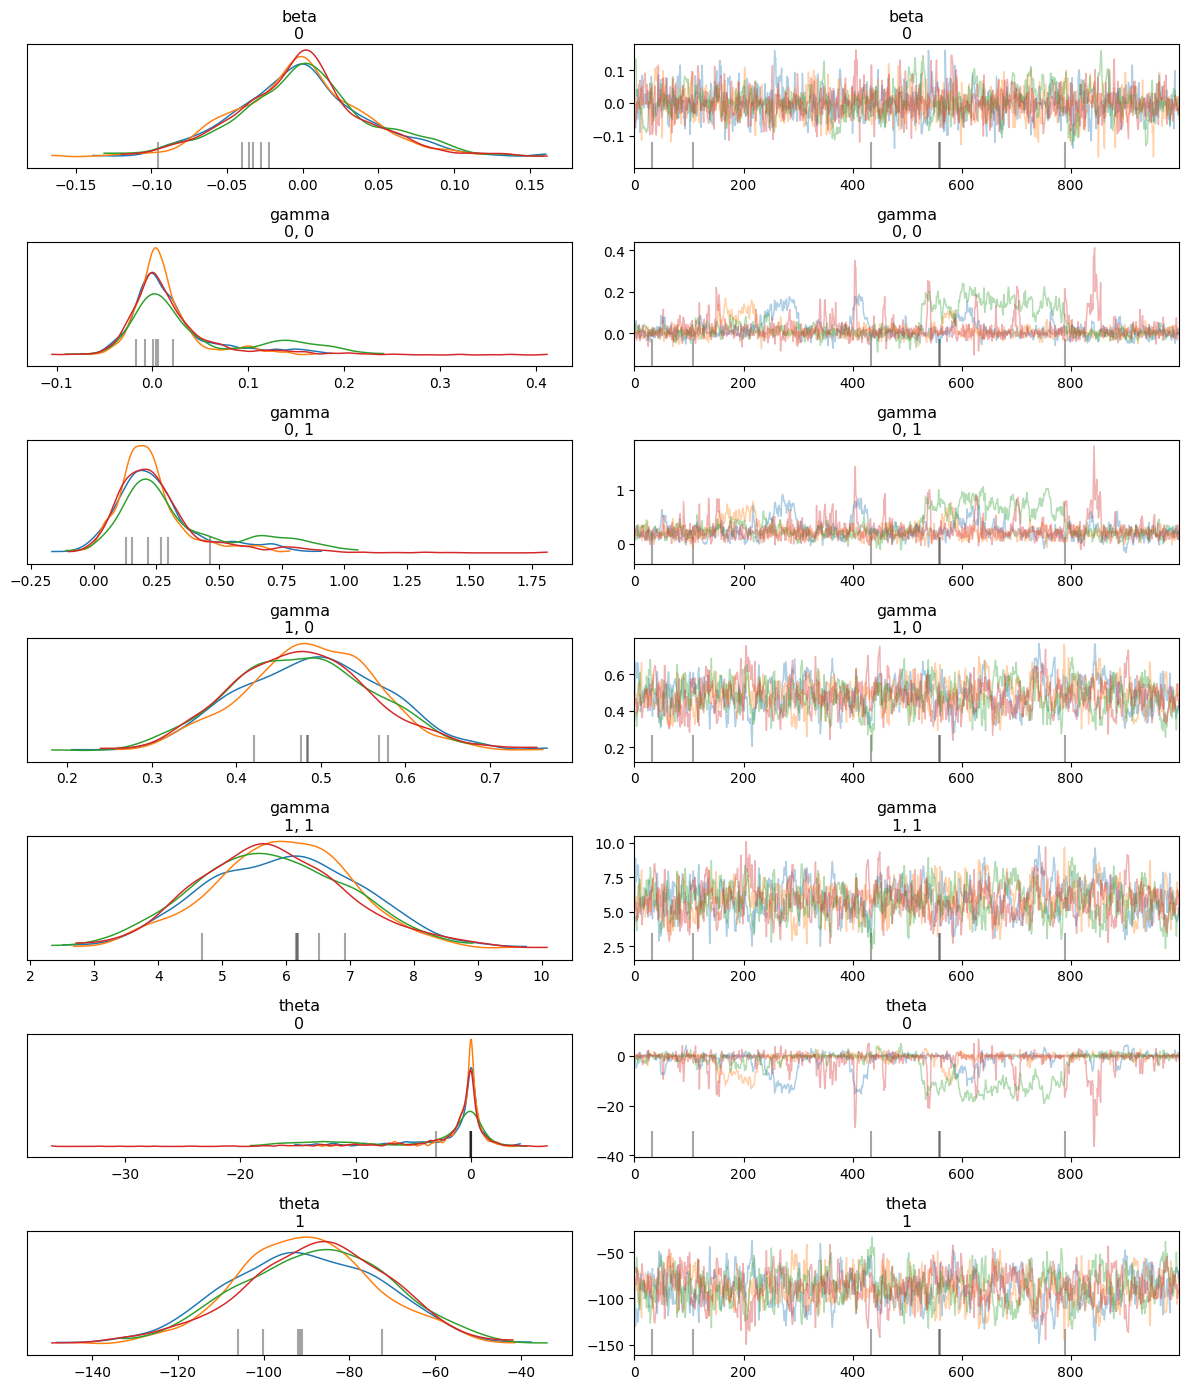

In [38]:
az.plot_trace(poi_glmm_rand_eff_data,
              var_names=["beta", "gamma", "theta"],
              compact=False)
plt.tight_layout()
plt.show()

In [39]:
poi_glmm_rand_eff_fit = poi_glmm_rand_eff.sample(
    data=glmm_randeff_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000, adapt_delta=0.95)

poi_glmm_rand_eff_data = az.from_cmdstanpy(poi_glmm_rand_eff_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glmm_rand_eff info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/bjwzmd__.json
21:43:04 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_eff', 'id=2', 'random', 'seed=68257', 'data', 'file=/tmp/tmpzu0qy9kr/bjwzmd__.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjpk8gvfv/poi_glmm_rand_eff-20250208214304_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_eff', 'id=4', 'random', 'seed=68257', 'data', 'file=/tmp/tmpzu0qy9kr/bjwzmd__.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjpk8gvfv/poi_glmm_rand_eff-20250208214304_4.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glmm_rand_

21:45:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glmm_rand_eff', 'id=1', 'random', 'seed=68257', 'data', 'file=/tmp/tmpzu0qy9kr/bjwzmd__.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glmm_rand_effjpk8gvfv/poi_glmm_rand_eff-20250208214304_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glmm_rand_effjpk8gvfv/poi_glmm_rand_eff-20250208214304_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glmm_rand_effjpk8gvfv/poi_glmm_rand_eff-20250208214304_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
    

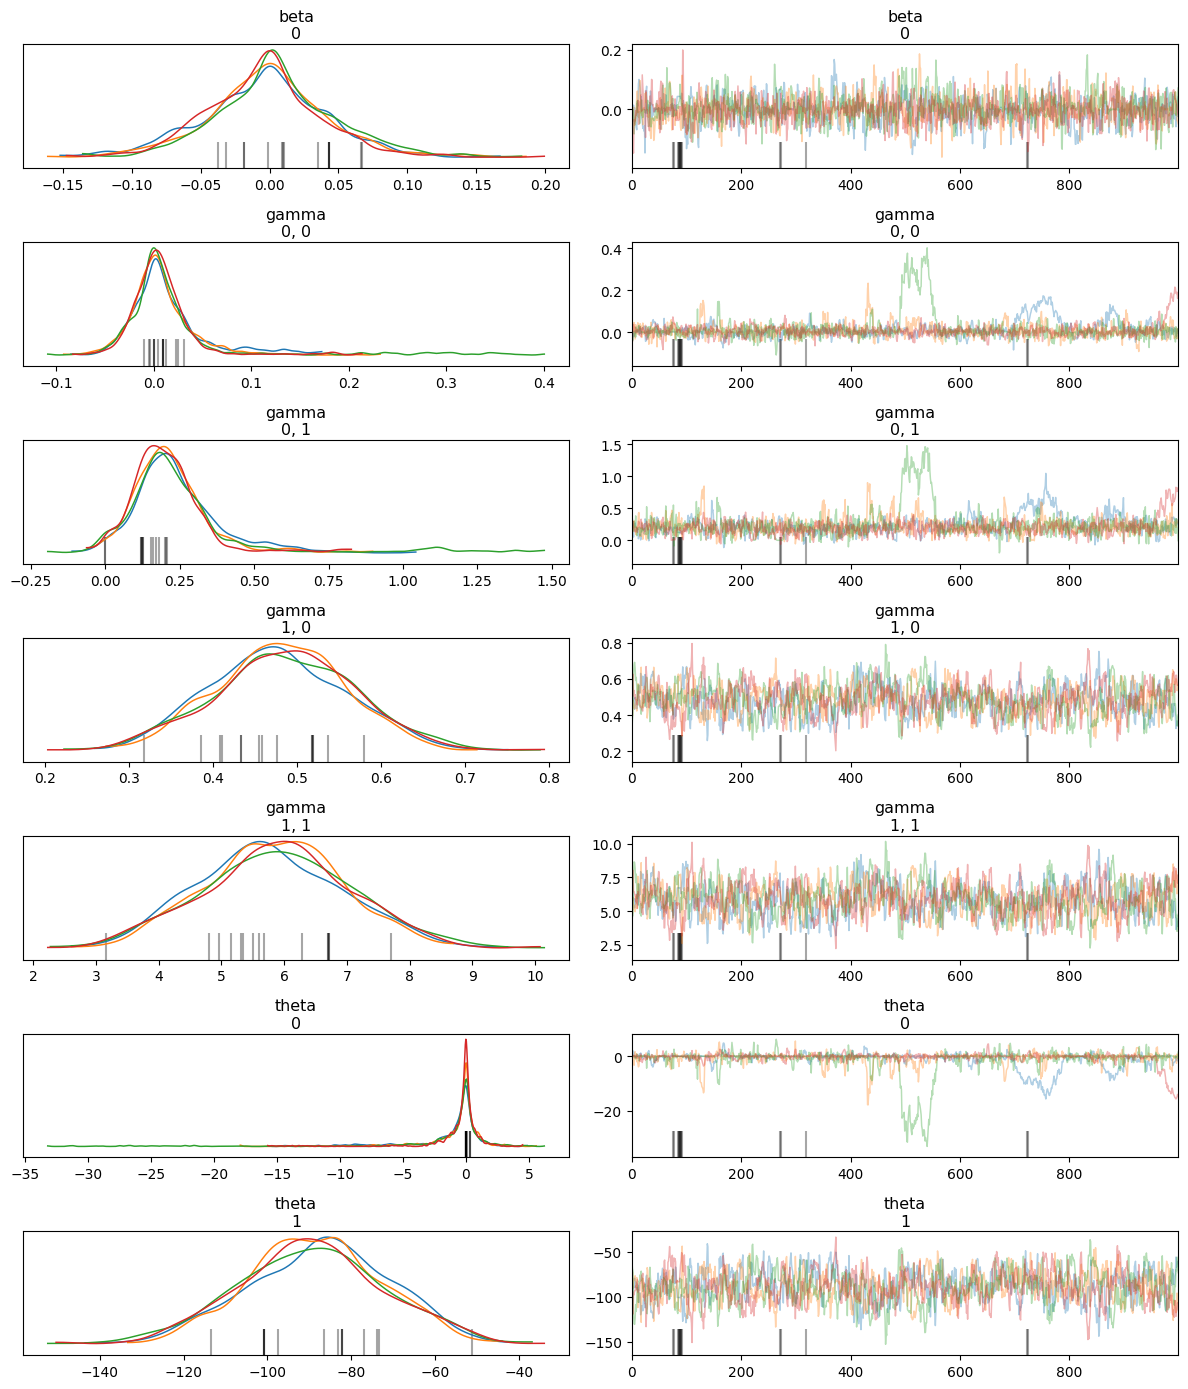

In [40]:
az.plot_trace(poi_glmm_rand_eff_data,
              var_names=["beta", "gamma", "theta"],
              compact=False)
plt.tight_layout()
plt.show()

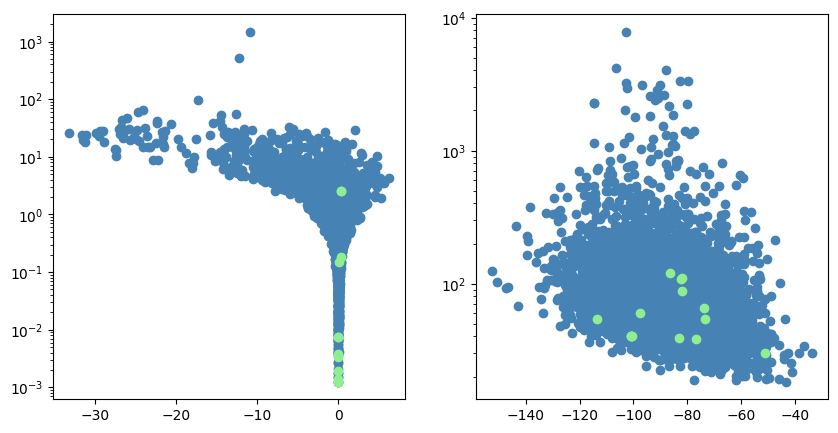

In [41]:
# Let's see where these divergences happen
def split_diverging(data, var_name):
    div_iters = np.where(data.sample_stats.diverging)
    non_div_iters = np.where(data.sample_stats.diverging == False)
    vals = data.posterior[var_name].values
    return (vals[div_iters[0], div_iters[1], :],
            vals[non_div_iters[0], non_div_iters[1], :])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

theta_div, theta_nondiv = split_diverging(poi_glmm_rand_eff_data, "theta")
sigma_theta_div, sigma_theta_nondiv = split_diverging(
    poi_glmm_rand_eff_data, "sigma_theta")

for i in range(2):
    axes[i].scatter(theta_nondiv[:, i], sigma_theta_nondiv[:, i], color="steelblue")
    axes[i].scatter(theta_div[:, i], sigma_theta_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")

Let's try reparametrizing the model as follows:
\begin{align*}
    \theta &= \sigma_\theta \cdot \theta_r \\
    \theta_r &\sim \mathcal{N}(0, 1) \\
    \sigma_\theta &\sim HC(0,1)
\end{align*}

In [42]:
poi_glm_rand_eff_reparam = """
data{
    int<lower = 0> N;
    int<lower = 0> ngr;
    int<lower = 0> nsubgr;

    int<lower = 0> p_fix;
    int<lower = 0> p_ran;

    array[N] int<lower = 0> Y;
    matrix[N, p_fix] X;
    matrix[N, p_ran] Z;

    array[N] int<lower=1, upper=ngr> group;
    array[N] int<lower=1, upper=nsubgr> subgroup;
}

parameters{
    vector[p_fix] beta;
    vector[ngr] theta_raw;
    matrix[ngr, p_ran] gamma;      // regression coefficients (random)
    vector[nsubgr] alpha;          // (group specific) random effects

    vector<lower=0>[p_fix] sigma_beta;        // variances for the prior on beta
    vector<lower=0>[ngr] sigma_theta;         // variances for the prior on theta
    matrix<lower=0>[ngr, p_ran] sigma_gamma;  // (group specific) random effects
    vector<lower=0>[nsubgr] sigma_alpha;      // (group specific) random effects
}

transformed parameters{
    vector[N] mu;
    vector[N] intercept;
    vector[N] fix_eff;
    vector[N] rand_eff;
    vector[ngr] theta;

    theta = sigma_theta .* theta_raw;

    intercept = theta[group] + alpha[subgroup];
    fix_eff = X * beta;
    for (i in 1:N) {
        rand_eff[i] = dot_product(Z[i], gamma[group[i]]);
    }

    mu = exp(intercept + fix_eff + rand_eff);
}

model{
    for (s in 1:N) {
        Y[s] ~ poisson(mu[s]);
    }

    for (j in 1:p_fix) {
        beta[j] ~ normal(0.0, sigma_beta[j]);
        sigma_beta[j] ~ cauchy(0, 1);
    }

    theta_raw ~ normal(0.0, 1.0);
    sigma_theta ~ cauchy(0, 1);

    for (j in 1:nsubgr){
        alpha[j] ~ normal(0.0, sigma_alpha);
        sigma_alpha[j] ~ cauchy(0, 1);
    }

    for (j in 1:p_ran) {
      for(i in 1:ngr){
        gamma[j,i] ~ normal(0.0, sigma_gamma[j,i]);
        sigma_gamma[j,i] ~ cauchy(0, 1);
      }
    }
}

generated quantities {
      vector[N] log_lik;
      for (j in 1:N){
            log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
      }
}
"""

# Write stan model to file
stan_file = "./stan/poi_glm_rand_eff_reparam.stan"
with open(stan_file, "w") as f:
    print(poi_glm_rand_eff_reparam, file=f)

# Compile stan model
poi_glmm_rand_eff2 = CmdStanModel(stan_file=stan_file)

21:50:25 - cmdstanpy - INFO - compiling stan file /content/stan/poi_glm_rand_eff_reparam.stan to exe file /content/stan/poi_glm_rand_eff_reparam
INFO:cmdstanpy:compiling stan file /content/stan/poi_glm_rand_eff_reparam.stan to exe file /content/stan/poi_glm_rand_eff_reparam
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poi_glm_rand_eff_reparam.stan /content/stan/poi_glm_rand_eff_reparam
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poi_glm_rand_eff_reparam.stan --o=/content/stan/poi_glm_rand_eff_reparam.hpp /content/stan/poi_glm_rand_eff_reparam.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/

In [43]:
poi_glmm_rand_eff_fit = poi_glmm_rand_eff2.sample(
    data=glmm_randeff_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

poi_glmm_rand_eff_data = az.from_cmdstanpy(poi_glmm_rand_eff_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glm_rand_eff_reparam info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/viyop1ag.json
21:51:35 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_reparam', 'id=1', 'random', 'seed=85526', 'data', 'file=/tmp/tmpzu0qy9kr/viyop1ag.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_reparamw13cl8wi/poi_glm_rand_eff_reparam-20250208215135_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_reparam', 'id=2', 'random', 'seed=85526', 'data', 'file=/tmp/tmpzu0qy9kr/viyop1ag.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_reparamw13cl8wi/poi_glm_rand_eff_reparam-20250208215135_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 

21:53:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glm_rand_eff_reparam', 'id=1', 'random', 'seed=85526', 'data', 'file=/tmp/tmpzu0qy9kr/viyop1ag.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_reparamw13cl8wi/poi_glm_rand_eff_reparam-20250208215135_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_reparamw13cl8wi/poi_glm_rand_eff_reparam-20250208215135_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_reparamw13cl8wi/poi_glm_rand_eff_reparam-20250208215135_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
  

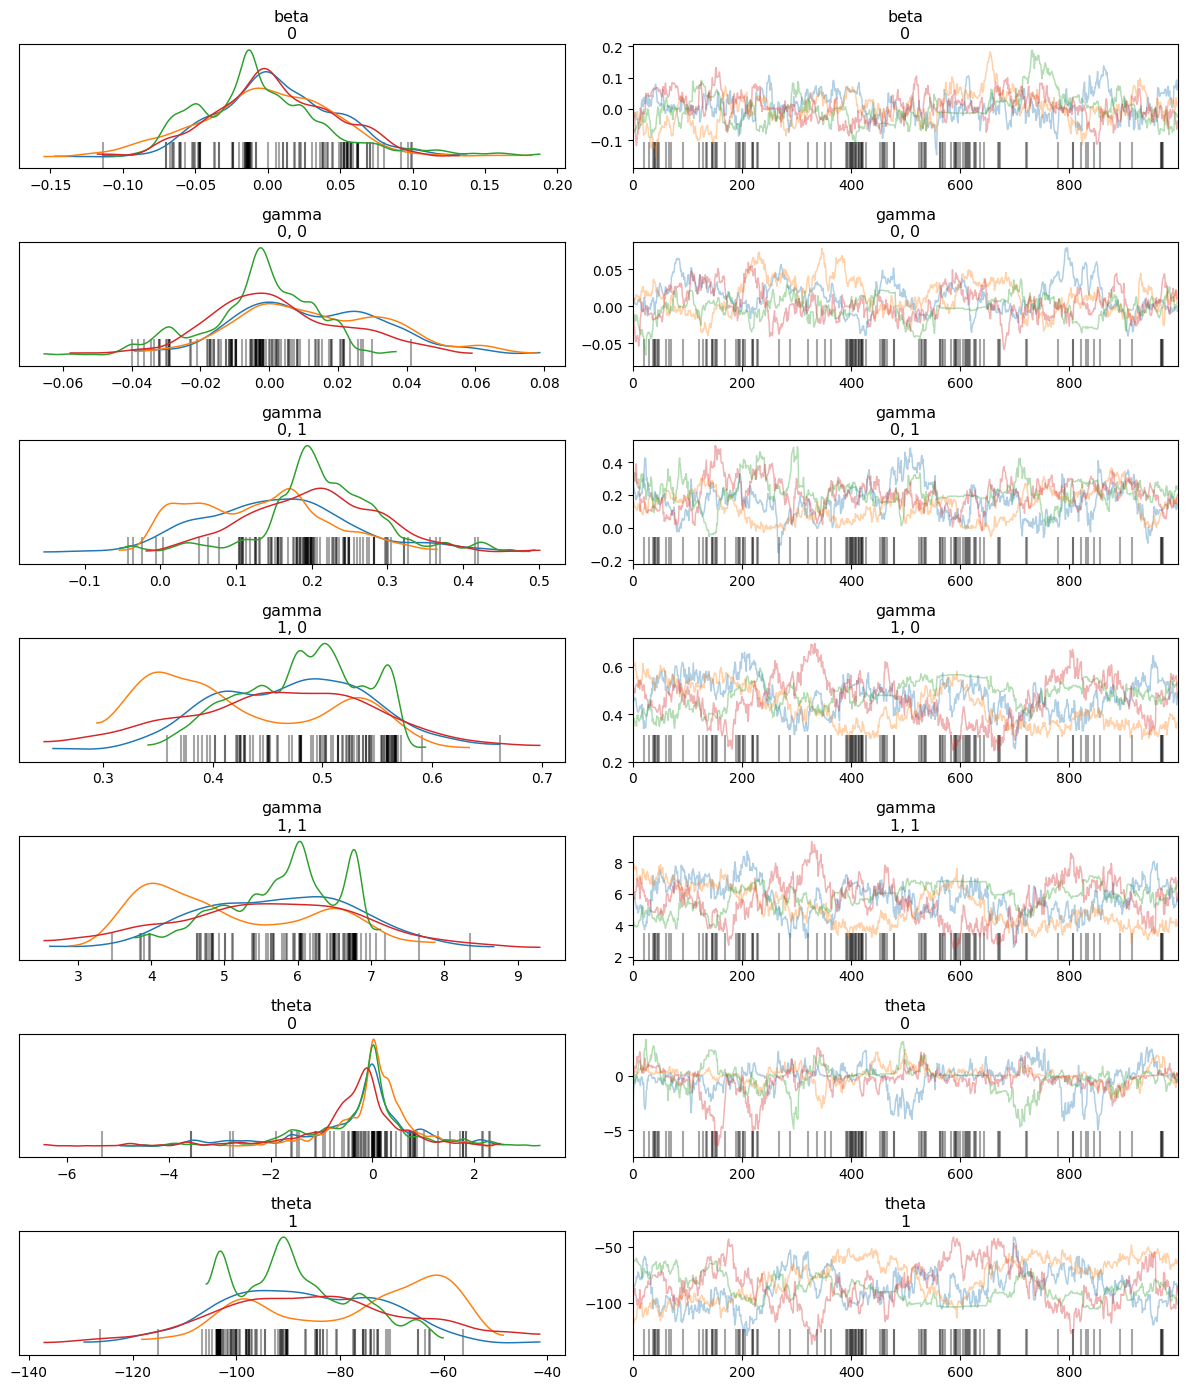

In [44]:
az.plot_trace(poi_glmm_rand_eff_data,
              var_names=["beta", "gamma", "theta"],
              compact=False)
plt.tight_layout()
plt.show()

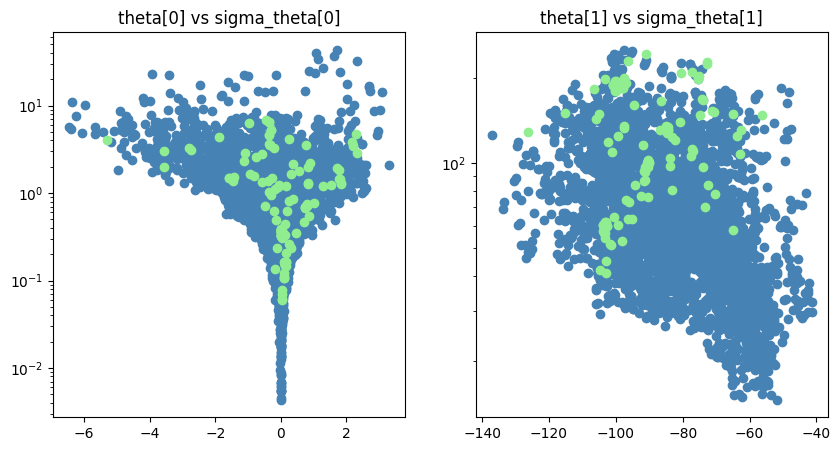

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

theta_div, theta_nondiv = split_diverging(poi_glmm_rand_eff_data, "theta")
sigma_theta_div, sigma_theta_nondiv = split_diverging(
    poi_glmm_rand_eff_data, "sigma_theta")

for i in range(2):
    axes[i].scatter(theta_nondiv[:, i], sigma_theta_nondiv[:, i], color="steelblue")
    axes[i].scatter(theta_div[:, i], sigma_theta_div[:, i], color="lightgreen")
    axes[i].set_yscale("log")
    axes[i].set_title("theta[{0}] vs sigma_theta[{0}]".format(i))

# We ditch theta and use a single intercept

We assume

\begin{equation*}
\begin{aligned}
    y_{i, j, r} & \sim \text{Poi}(\mu_{i, j, r}) \\
    \mu_{i, j, r} &= \exp(\theta + \alpha_{j, r} + \beta^T x_i + \gamma_j^T z_{i, j} )
\end{aligned}
\end{equation*}

In [46]:
poi_glm_rand_eff_notheta = """
data{
    int<lower = 0> N;
    int<lower = 0> ngr;
    int<lower = 0> nsubgr;

    int<lower = 0> p_fix;
    int<lower = 0> p_ran;

    array[N] int<lower = 0> Y;
    matrix[N, p_fix] X;
    matrix[N, p_ran] Z;

    array[N] int<lower=1, upper=ngr> group;
    array[N] int<lower=1, upper=nsubgr> subgroup;
}

parameters{
    vector[p_fix] beta;
    matrix[ngr, p_ran] gamma;      // regression coefficients (random)
    vector[nsubgr] alpha;          // (group specific) random effects

    vector<lower=0>[p_fix] sigma_beta;        // variances for the prior on beta
    matrix<lower=0>[ngr, p_ran] sigma_gamma;  // (group specific) random effects
    vector<lower=0>[nsubgr] sigma_alpha;      // (group specific) random effects
}

transformed parameters{
    vector[N] mu;
    vector[N] intercept;
    vector[N] fix_eff;
    vector[N] rand_eff;

    intercept = alpha[subgroup];
    fix_eff = X * beta;
    for (i in 1:N) {
        rand_eff[i] = dot_product(Z[i], gamma[group[i]]);
    }

    mu = exp(intercept + fix_eff + rand_eff);
}

model{
    for (s in 1:N) {
        Y[s] ~ poisson(mu[s]);
    }

    for (j in 1:p_fix) {
        beta[j] ~ normal(0.0, sigma_beta[j]);
        sigma_beta[j] ~ cauchy(0, 1);
    }

    for (j in 1:nsubgr){
        alpha[j] ~ normal(0.0, sigma_alpha);
        sigma_alpha[j] ~ cauchy(0, 1);
    }

    for (j in 1:p_ran) {
      for(i in 1:ngr){
        gamma[j,i] ~ normal(0.0, sigma_gamma[j,i]);
        sigma_gamma[j,i] ~ cauchy(0, 1);
      }
    }

}

generated quantities {
      vector[N] log_lik;
      for (j in 1:N){
            log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
      }
}
"""

# Write stan model to file
stan_file = "./stan/poi_glm_rand_eff_notheta.stan"
with open(stan_file, "w") as f:
    print(poi_glm_rand_eff_notheta, file=f)

# Compile stan model
poi_glm_rand_eff_notheta = CmdStanModel(stan_file=stan_file)

21:59:03 - cmdstanpy - INFO - compiling stan file /content/stan/poi_glm_rand_eff_notheta.stan to exe file /content/stan/poi_glm_rand_eff_notheta
INFO:cmdstanpy:compiling stan file /content/stan/poi_glm_rand_eff_notheta.stan to exe file /content/stan/poi_glm_rand_eff_notheta
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poi_glm_rand_eff_notheta.stan /content/stan/poi_glm_rand_eff_notheta
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poi_glm_rand_eff_notheta.stan --o=/content/stan/poi_glm_rand_eff_notheta.hpp /content/stan/poi_glm_rand_eff_notheta.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/

In [47]:
X_w1 = np.hstack([np.ones(len(y)).reshape(-1, 1), X])

glmm_randeff_data = {
    "N": len(y),
    "ngr": len(np.unique(group)),
    "nsubgr": len(np.unique(subgroup)),
    "p_fix": X_w1.shape[1],
    "p_ran": Z.shape[1],
    "Y": y,
    "X": X_w1,
    "Z": Z,
    "group": group,
    "subgroup": subgroup
}

In [48]:
poi_glmm_rand_eff_fit = poi_glm_rand_eff_notheta.sample(
    data=glmm_randeff_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

poi_glmm_rand_eff_data = az.from_cmdstanpy(poi_glmm_rand_eff_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glm_rand_eff_notheta info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/o2cpqunw.json
22:05:05 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_notheta', 'id=1', 'random', 'seed=82437', 'data', 'file=/tmp/tmpzu0qy9kr/o2cpqunw.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_notheta', 'id=2', 'random', 'seed=82437', 'data', 'file=/tmp/tmpzu0qy9kr/o2cpqunw.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_nothe

22:07:29 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glm_rand_eff_notheta', 'id=1', 'random', 'seed=82437', 'data', 'file=/tmp/tmpzu0qy9kr/o2cpqunw.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
  

In [49]:
poi_glmm_rand_eff_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpzu0qy9kr/stansummary-poi_glm_rand_eff_notheta-gbcjc6n5.csv /tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_1.csv /tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_2.csv /tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_3.csv /tmp/tmpzu0qy9kr/poi_glm_rand_eff_nothetailumn1pk/poi_glm_rand_eff_notheta-20250208220505_4.csv
cwd: None


Mean      MCSE     StdDev        MAD          5%  \
lp__         851.079000  0.103943   3.721670   3.594560  844.414000   
beta[1]      -37.584100  0.582174  11.034600  10.764100  -55.686200   
beta[2]        0.091210  0.001170   0.054547   0.055446    0.004565   
gamma[1,1]     0.423942  0.006830   0.130033   0.127492    0.216940   
gamma[1,2]     1.670340  0.022568   0.437743   0.430362    0.968710   
...                 ...       ...        ...        ...         ...   
log_lik[56]   -2.086500  0.001433   0.083901   0.036628   -2.253720   
log_lik[57]   -2.834740  0.008433   0.463066   0.464617   -3.655260   
log_lik[58]  -24.464100  0.054157   3.008510   3.013900  -29.767700   
log_lik[59]   -4.696260  0.053474   1.205460   1.179680   -6.904260   
log_lik[60]   -1.925740  0.021067   0.465206   0.395054   -2.790090   

                    50%         95%  ESS_bulk  ESS_tail     R_hat  
lp__         851.490000  856.457000  1327.580  2228.790  1.000600  
beta[1]      -37.746600  -19.870900   369.230   562.125  1.016070  
beta[2]        0.089257    0.183071  2228.310  2553.260  1.001980  
gamma[1,1]     0.426523    0.638850   372.856   577.250  1.016690  
gamma[1,2]     1.674130    2.388840   385.699   612.852  1.014420  
...                 ...         ...       ...       ...       ...  
log_lik[56]   -2.054310   -2.027100  3557.610  3705.690  0.999542  
log_lik[57]   -2.783970   -2.155870  3145.160  3584.090  1.001090  
log_lik[58]  -24.347000  -19.797100  3145.240  3584.090  1.001090  
log_lik[59]   -4.601660   -2.952680   506.157   822.280  1.011940  
log_lik[60]   -1.818030   -1.373460   510.681   822.280  1.011970  

[325 rows x 10 columns]

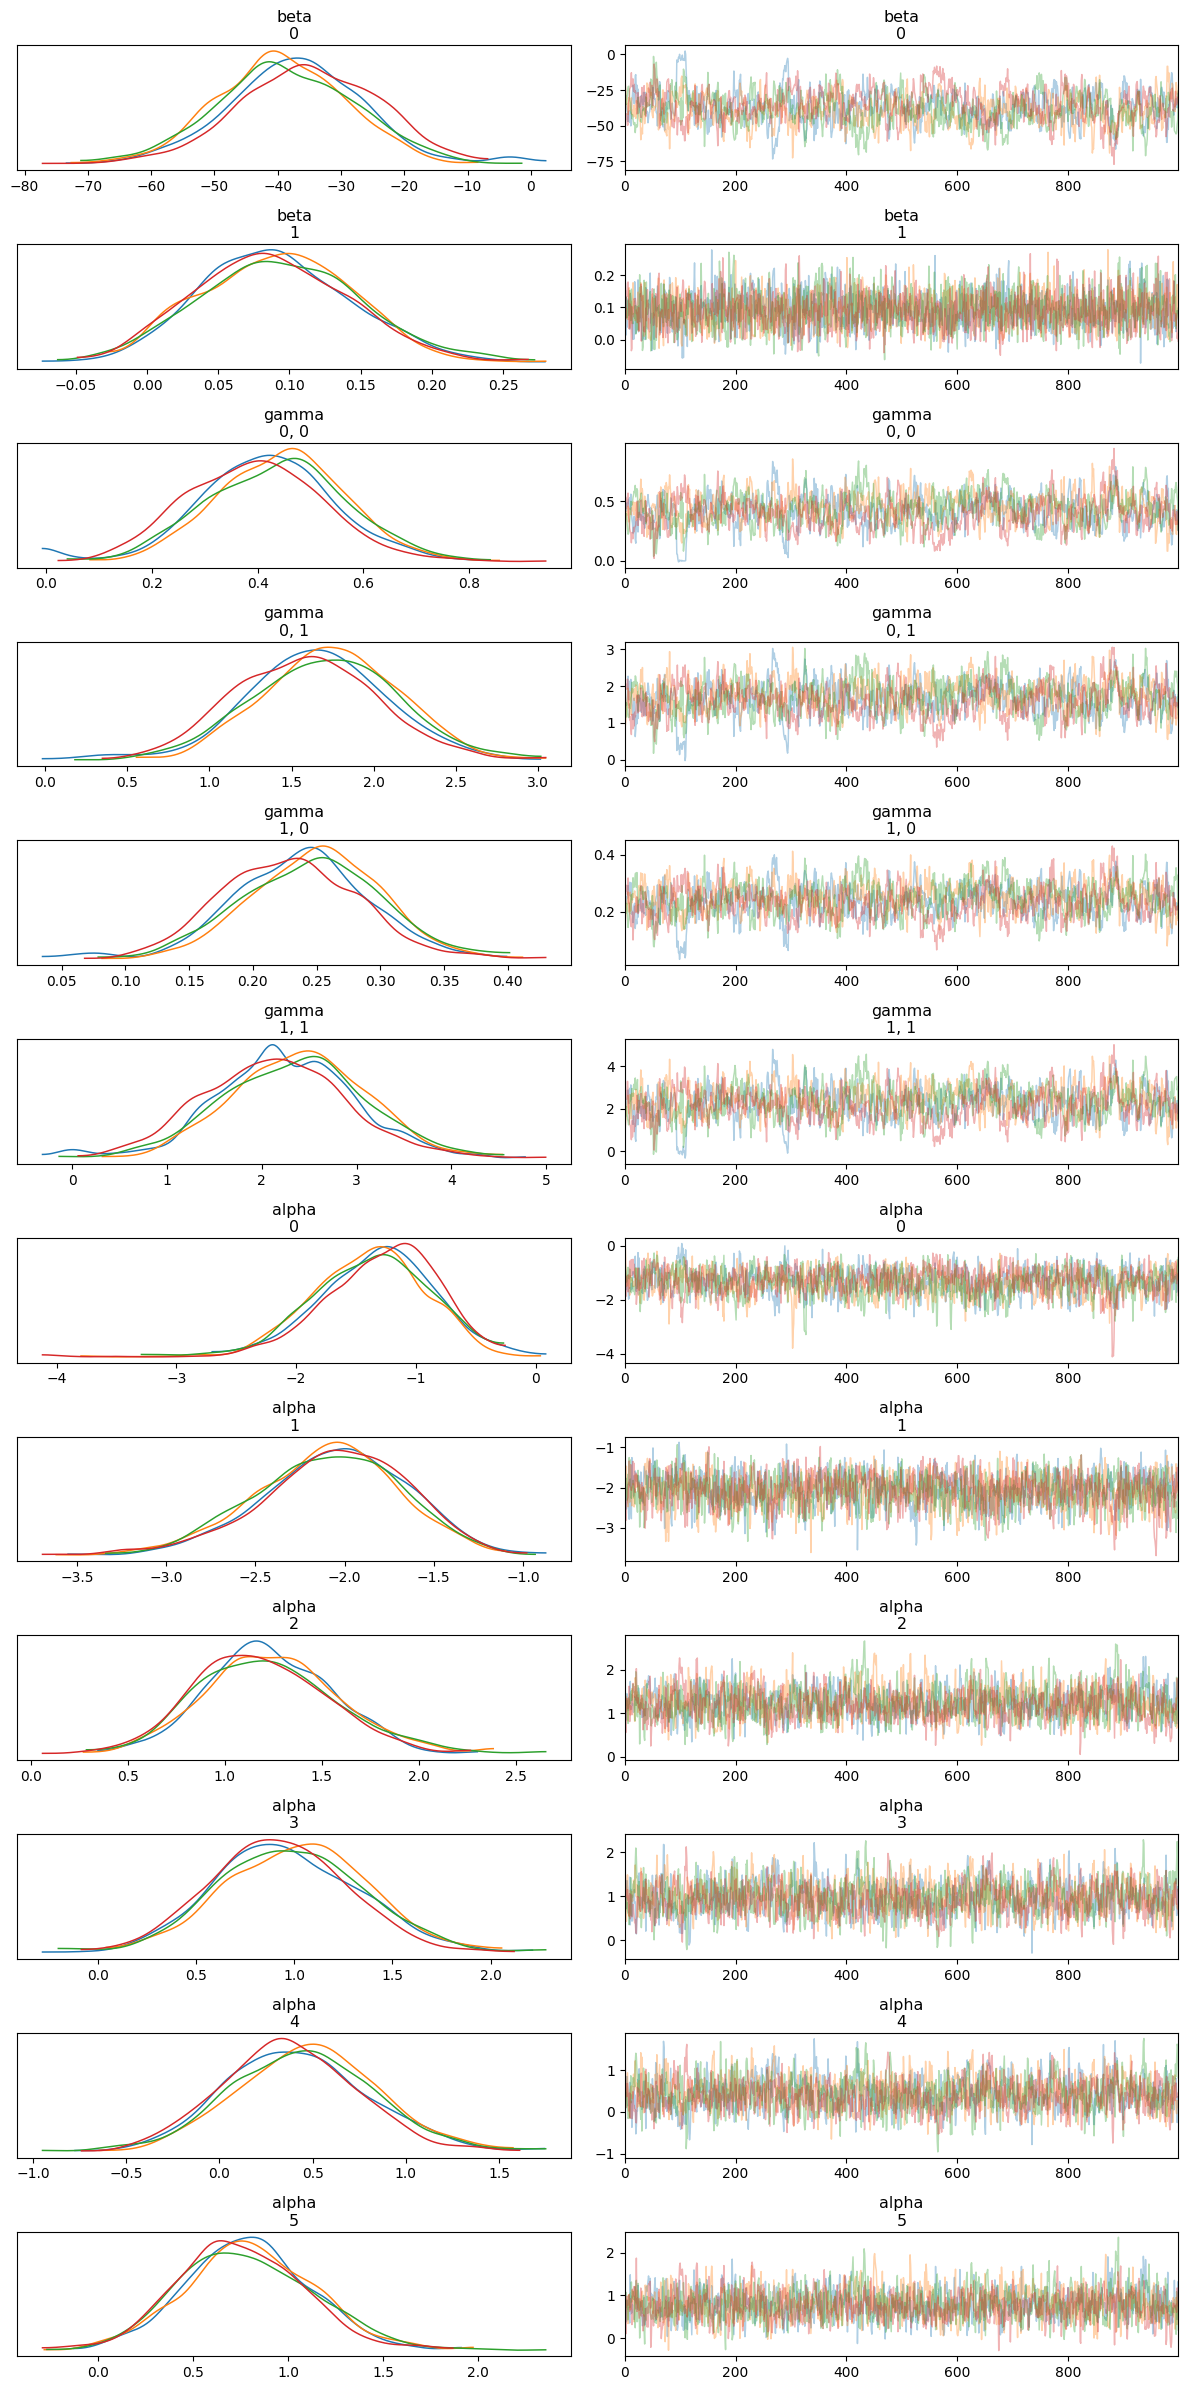

In [50]:
az.plot_trace(poi_glmm_rand_eff_data,
              var_names=["beta", "gamma", "alpha"],
              compact=False)
plt.tight_layout()
plt.show()

# Only now we can comment on the inference!

# Other errors and trials

In [51]:
poi_glm_rand_eff_mixcent = """
data{
    int<lower = 0> N;
    int<lower = 0> ngr;
    int<lower = 0> nsubgr;

    int<lower = 0> p_fix;
    int<lower = 0> p_ran;

    array[N] int<lower = 0> Y;
    matrix[N, p_fix] X;
    matrix[N, p_ran] Z;

    array[N] int<lower=1, upper=ngr> group;
    array[N] int<lower=1, upper=nsubgr> subgroup;
}

parameters{
    vector[p_fix] beta;
    matrix[ngr, p_ran] gamma;      // regression coefficients (random)
    vector[ngr] theta;
    vector[nsubgr] alpha;          // (group specific) random effects

    vector<lower=0>[p_fix] sigma_beta;        // variances for the prior on beta
    matrix<lower=0>[ngr, p_ran] sigma_gamma;  // (group specific) random effects
    vector<lower=0>[nsubgr] sigma_alpha;      // (group specific) random effects
}

transformed parameters{
    vector[N] mu;
    vector[N] intercept;
    vector[N] fix_eff;
    vector[N] rand_eff;

    intercept = theta[group] + alpha[subgroup];
    fix_eff = X * beta;
    for (i in 1:N) {
        rand_eff[i] = dot_product(Z[i], gamma[group[i]]);
    }

    mu = exp(intercept + fix_eff + rand_eff);
}

model{
    Y ~ poisson(mu);

    beta ~ normal(rep_vector(0, p_fix), sigma_beta);
    sigma_beta ~ cauchy(0, 1);

    alpha ~ normal(0.0, sigma_alpha);
    sigma_alpha ~ cauchy(0, 1);

    to_vector(sigma_gamma) ~ cauchy(0, 1);
    to_vector(gamma) ~ normal(0, to_vector(sigma_gamma));
}

generated quantities {
      vector[N] log_lik;
      for (j in 1:N){
            log_lik[j] = poisson_lpmf(Y[j] | mu[j]);
      }
}
"""

# Write stan model to file
stan_file = "./stan/poi_glm_rand_eff_mixcen.stan"
with open(stan_file, "w") as f:
    print(poi_glm_rand_eff_mixcent, file=f)

# Compile stan model
poi_glm_rand_eff_mixcent = CmdStanModel(stan_file=stan_file)

22:08:13 - cmdstanpy - INFO - compiling stan file /content/stan/poi_glm_rand_eff_mixcen.stan to exe file /content/stan/poi_glm_rand_eff_mixcen
INFO:cmdstanpy:compiling stan file /content/stan/poi_glm_rand_eff_mixcen.stan to exe file /content/stan/poi_glm_rand_eff_mixcen
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poi_glm_rand_eff_mixcen.stan /content/stan/poi_glm_rand_eff_mixcen
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poi_glm_rand_eff_mixcen.stan --o=/content/stan/poi_glm_rand_eff_mixcen.hpp /content/stan/poi_glm_rand_eff_mixcen.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.8

In [52]:
poi_glmm_fit = poi_glm_rand_eff_mixcent.sample(
    data=glmm_randeff_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

poi_glmm_data = az.from_cmdstanpy(poi_glmm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/poi_glm_rand_eff_mixcen info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzu0qy9kr/j5jsgp2i.json
22:09:06 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_mixcen', 'id=1', 'random', 'seed=93247', 'data', 'file=/tmp/tmpzu0qy9kr/j5jsgp2i.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_mixcennwt1255w/poi_glm_rand_eff_mixcen-20250208220906_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_mixcen', 'id=2', 'random', 'seed=93247', 'data', 'file=/tmp/tmpzu0qy9kr/j5jsgp2i.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_mixcennwt1255w/poi_glm_rand_eff_mixcen-20250208220906_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/poi_glm_rand_eff_mixcen', 'i

22:11:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/poi_glm_rand_eff_mixcen', 'id=1', 'random', 'seed=93247', 'data', 'file=/tmp/tmpzu0qy9kr/j5jsgp2i.json', 'output', 'file=/tmp/tmpzu0qy9kr/poi_glm_rand_eff_mixcennwt1255w/poi_glm_rand_eff_mixcen-20250208220906_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_mixcennwt1255w/poi_glm_rand_eff_mixcen-20250208220906_1.csv
 console_msgs (if any):
	/tmp/tmpzu0qy9kr/poi_glm_rand_eff_mixcennwt1255w/poi_glm_rand_eff_mixcen-20250208220906_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin 

22:11:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 1 had 992 iterations at max treedepth (99.2%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 2 had 973 iterations at max treedepth (97.3%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 3 had 942 iterations at max treedepth (94.2%)
	Chain 4 had 3 divergent transitions (0.3%)
	Chain 4 had 965 iterations at max treedepth (96.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 1 had 992 iterations at max treedepth (99.2%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 2 had 973 iterations at max treedepth (97.3%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 3 had 942 iterations at max treedepth (94.2%)
	Chain 4 had 3 divergent transitions (0.3%)
	Chain 4 had 965 iterations at max treedepth (96.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see furth

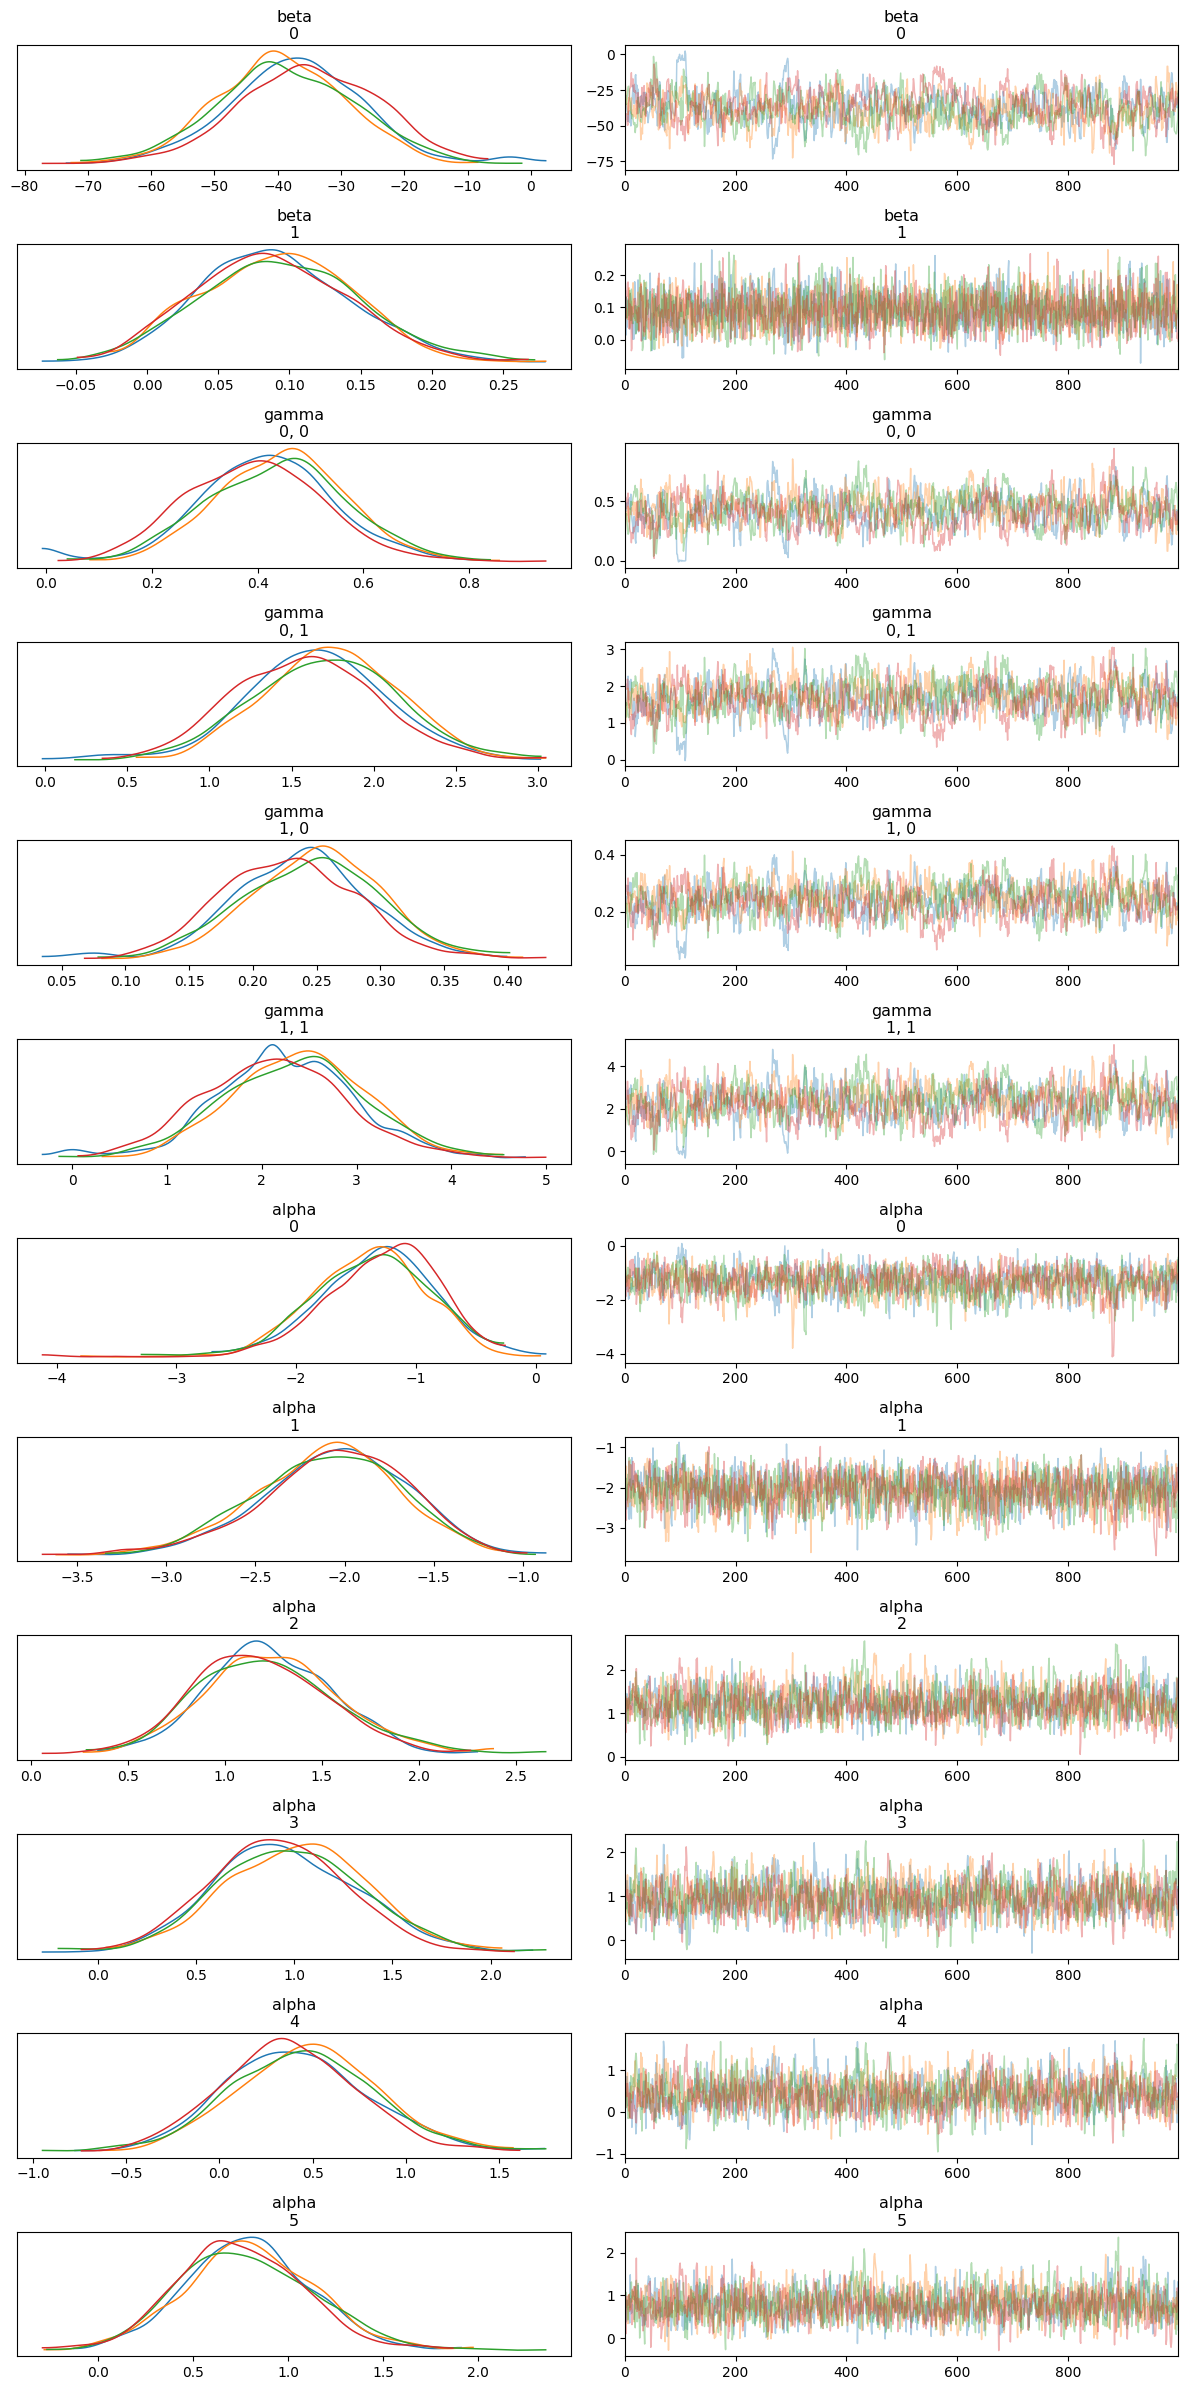

In [53]:
az.plot_trace(poi_glmm_rand_eff_data,
              var_names=["beta", "gamma", "alpha"],
              compact=False)
plt.tight_layout()
plt.show()